In [1]:
import pandas as pd
from sklearn.metrics.scorer import make_scorer
from sklearn import linear_model
from sklearn import metrics
df = pd.read_csv('topic.csv')
df.head()
col = ['annotation', 'title','body']
df = df[col]
df['category_id'] = df['annotation'].factorize()[0]
from io import StringIO
category_id_df = df[['annotation', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'annotation']].values)
print(category_id_df)
labels = df.category_id

                  annotation  category_id
0                   Business            0
204            Entertainment            1
617                    Error            2
646                   Health            3
721                    Other            4
765                 Politics            5
1104  Science and Technology            6
1233                 Society            7
1925                  Sports            8
2213                     War            9


In [2]:
#lemmatizer and add synset for title
import string
from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import nltk
import time
punct = set(string.punctuation)
#print(punct)
wordEngStop = nltk.corpus.stopwords.words('english')
one_title = []
titles = []
synsets = []
synset1 = []
synset2 = []
lemmatizer = WordNetLemmatizer()
for title in df.title:
    for token,tag in pos_tag(word_tokenize(title)):
        
            token = token.lower()
            token = token.strip()
            token = token.strip('_')
            token = token.strip('*')
            if token in wordEngStop:
                continue
            if all(char in punct for char in token):
                continue
                
            tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
             }.get(tag[0], wn.NOUN)
            lemma = lemmatizer.lemmatize(token,tag)
            syn = wn.synsets(lemma)
            a = len(syn)
            if a > 10:
                synset1 = [syn[i].lemmas()[0].name() for i in range(0,10)] 
            else:
                synset2 = [syn[i].lemmas()[0].name() for i in range(0,a)] 
            synsets = synset1 + synset2

    synsets.append(title)
    a = ' '
    one_article = a.join(synsets)
    titles.append(one_article)
    synsets.clear()
    

In [3]:
#clean title
import re
import string
titles_new=[]
for i in titles:
    i = i.lower()
    i = re.sub('[^a-z]',' ',i)
    titles_new.append(i)
print(len(titles_new))

2284


In [4]:
#Lemmatizer body
import string
from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag
import nltk
import time

print(time.time())
punct = set(string.punctuation)
wordEngStop = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()
lemas =[]
lema = []
for article in df.body:
    for sent in sent_tokenize(article):
        for token,tag in pos_tag(wordpunct_tokenize(sent)):
            token = token.lower()
            token = token.strip()
            token = token.strip('_')
            token = token.strip('*')
          
            if token in wordEngStop:
                continue
            if all(char in punct for char in token):
                continue
            tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
             }.get(tag[0], wn.NOUN)
            lemma = lemmatizer.lemmatize(token, tag)
            lema.append(lemma)
    a = ' '
    one_article = a.join(lema)
    lemas.append(one_article)
    lema.clear()

1525675030.022957


In [5]:
print(len(titles_new))

body_title =[]
for i in range(len(titles_new)):
        a = titles_new[i]+' '+ lemas[i]
        a = re.sub('[^a-z]',' ',a)
        body_title.append(a)


2284


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(sublinear_tf=True, max_df=0.46, norm='l2', encoding='latin-1', stop_words='english')
tfidf = vec.fit_transform(body_title)

In [11]:
#ten-fold
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
max_df=[0.51,0.52,0.53,0.55,0,56,0.57,0.58,0.59]
tfidf = TfidfVectorizer(sublinear_tf=True, max_df=0.45, norm='l2', encoding='latin-1', stop_words='english')
tfidf = tfidf.fit_transform(body_title)
kfold = model_selection.KFold(n_splits=10, random_state=7)
sfolder = StratifiedKFold(n_splits=10,random_state=0)
modelCV = LogisticRegression(C=1.0, class_weight='balanced')
#C=1e5, class_weight='balanced'
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, tfidf, labels, cv=sfolder, scoring=scoring)
for i in results:
    print(i)
print("10-fold cross validation average accuracy: %.4f" % (results.mean()))

0.6781115879828327
0.7198275862068966
0.7186147186147186
0.717391304347826
0.6885964912280702
0.7709251101321586
0.6607929515418502
0.7136563876651982
0.7345132743362832
0.7533632286995515
10-fold cross validation average accuracy: 0.7156


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, max_df=0.45, norm='l2', encoding='latin-1', stop_words='english')
tfidf = tfidf.fit_transform(body_title)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(tfidf,labels,random_state = 0,test_size = 0.2)
labels = df.category_id

logreg = LogisticRegression(C=1.0,class_weight='balanced')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Accuracy of logistic regression classifier on test set: {:.6f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.757112


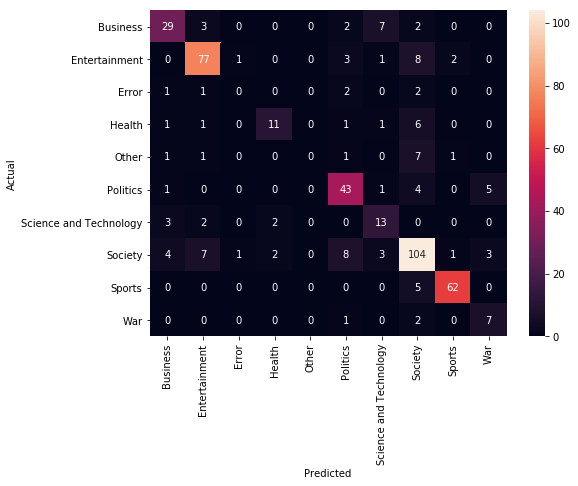

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
conf_mat   
df_cm = pd.DataFrame(conf_mat)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(df_cm, annot=True, fmt='d', xticklabels=category_id_df.annotation.values, yticklabels=category_id_df.annotation.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [19]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['annotation'].unique()))

                        precision    recall  f1-score   support

              Business       0.72      0.67      0.70        43
         Entertainment       0.84      0.84      0.84        92
                 Error       0.00      0.00      0.00         6
                Health       0.73      0.52      0.61        21
                 Other       0.00      0.00      0.00        11
              Politics       0.70      0.80      0.75        54
Science and Technology       0.50      0.65      0.57        20
               Society       0.74      0.78      0.76       133
                Sports       0.94      0.93      0.93        67
                   War       0.47      0.70      0.56        10

           avg / total       0.74      0.76      0.75       457



/Users/guoguo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [20]:
from sklearn.feature_selection import chi2
import numpy as np
N = 10
for annotation, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(tfidf, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(vec.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print(" '{}':".format(annotation),end='')
    print(" {}".format('. '.join(unigrams[-N:])),end='')
    print('')

 'Business': produces. analyst. consumed. prez. resuscitate. grows. companionship. saldana. investment. markedly
 'Entertainment': mushrooms. sondheim. band. album. singapore. mover. stanza. actress. actor. filly
 'Error': knead. ofcourse. shepparton. ligue. ectoplasm. edmondson. internationally. malleschitz. sets. loftus
 'Health': psychiatric. studiously. gender. policymaker. virtuoso. disdainful. outbound. symphony. cancer. ebert
 'Other': tin. vxo. zikalala. gorman. panamera. cabral. creature. koa. tapes. mackay
 'Politics': parturiency. primary. bjp. governing. repubblica. preside. modestly. ob. miniskirt. electing
 'Science and Technology': metastasize. ipenz. scientific. teleprompter. asteroid. smartly. technological. android. smartest. narsinghpur
 'Society': courses. incidence. car. gambling. murat. prosecuting. vicky. arrest. offers. pole
 'Sports': teacup. cuomo. arsenal. wimmera. seaside. coach. matarau. leafy. playdates. gambling
 'War': python. al. caliphate. fightback. s

In [13]:
from IPython.display import display

for predicted in category_id_df.category_id:
      for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 6:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['annotation', 'body']])
            print('')

'Society' predicted as 'Business' : 9 examples.


,annotation,body
1248,Society,The U.S. dollar rose to a four-year high as Go...
1758,Society,Railway Recruitment Board (RRB) in Bhopal has ...
1545,Society,\nbrotherhood00\nStep forward: The 20-year red...
1696,Society,"Paris - Border closures, quarantines and crop ..."
1878,Society,"PARIS (AFP) - Products with the ""Je Suis Charl..."
1495,Society,The Philippines will spend $3.89bn to rehouse ...
1826,Society,The World Bank estimates that more than 250 mi...
1861,Society,\n\nIndia's monsoon rainfall was 22 percent be...
1714,Society,The American Corn snake was seen at Kawana Sou...



'Society' predicted as 'Entertainment' : 18 examples.


,annotation,body
1486,Society,Harry Patch by Radiohead.\nA magnificently sco...
1477,Society,Strangers have come to the aid of the family o...
1261,Society,If you can count on anything during the holida...
1585,Society,Just hours remain to bid on unique experiences...
1513,Society,Published 21/01/2015 | 09:23\nColin Farrell ha...
1426,Society,Police supervise as protesters march from Rund...
1870,Society,BACKLASH: Our opinions on the most talked abou...
1387,Society,Saturday was supposed to be the day that Britt...
1811,Society,Thea is a 12-year-old bride-to-be who is set t...
1533,Society,Serried ranks: Dame Marie Bashir inspects the ...



'Society' predicted as 'Politics' : 15 examples.


,annotation,body
1439,Society,By Joanne Sweeney - 05 January 2015\nThe socia...
1379,Society,"Without fail every year, starting around Novem..."
1774,Society,BENGALURU: To bolster their case for a ban on ...
1757,Society,It's Biden in the buff.\nA forthcoming book th...
1902,Society,Samuel de Champlain founded a nation in New Fr...
1376,Society,\nPublished 04/10/2014 | 02:30\nTaoiseach Enda...
1637,Society,Former Family Court Chief Justice Alastair Nic...
1349,Society,It will be a unique Diwali for widows of Vrind...
1665,Society,Johannesburg - The appointment of Fikile-Ntsik...
1557,Society,Concerned: Dickson resident Kevin Graham fears...



'Business' predicted as 'Science and Technology' : 9 examples.


,annotation,body
132,Business,On the heels of a major launch of large-screen...
10,Business,"Kim Dotcom, the infamous entrepreneur behind M..."
98,Business,The city's next generation of female computer ...
182,Business,Air New Zealand CEO Christopher Luxon has no t...
133,Business,"Curious, the video-enabled tutoring and teachi..."
33,Business,Apple's bending iPhone issue remains a hot top...
37,Business,Cadillac is gearing up to take on the best lux...
43,Business,"After a tumultuous launch this year, Xiaomi sa..."
58,Business,Custom 3D printed earphone company Normal will...



'Business' predicted as 'Society' : 14 examples.


,annotation,body
124,Business,The creator of ShipYourEnemiesGlitter.com just...
53,Business,Depression. Anxiety. Pain. Stress. Fatigue. Be...
27,Business,"On Tuesday, on the eve of China's 10th Zhuhai ..."
145,Business,Once there was no acronym more exclusive in th...
6,Business,A sea plane service that began today connects ...
161,Business,Our leader and briefing on corporate settlemen...
77,Business,By Nevin Farrell - 15 December 2014\nRepricerE...
85,Business,What was trash in the eyes of the government t...
202,Business,A map of the search area for the AirAsia plane...
187,Business,Leaders often find themselves getting lost wit...



'Entertainment' predicted as 'Society' : 19 examples.


,annotation,body
353,Entertainment,"In his latest brush with the law, pop singer J..."
535,Entertainment,"Sunday, November 30, 2014\n\nAs curator of the..."
568,Entertainment,On a Venice boardwalk stocked with memorably B...
478,Entertainment,Let friends in your social network know what y...
361,Entertainment,Johannesburg - Paralympian Oscar Pistorius has...
422,Entertainment,Photos and video captured of a suspected UFO f...
283,Entertainment,Award winning TV chef Gordon Ramsay felt his f...
600,Entertainment,HAUNTED STATION?: Lemington Spa station certai...
287,Entertainment,The delicate operation to remove a crossbow bo...
279,Entertainment,"If you're not in college, there aren't many th..."



'Health' predicted as 'Society' : 20 examples.


,annotation,body
703,Health,Ebola is having catastrophic economic conseque...
648,Health,The government has launched four pilot schemes...
711,Health,What appears to be the start of a zombie apoca...
684,Health,Sally and her husband Simon at last year's Cit...
682,Health,When most people around us are overweight or o...
686,Health,"Anxious, jealous, moody or distressed middle a..."
661,Health,\nIt is ten times harder for a woman to become...
670,Health,A new gene-therapy treatment is showing promis...
655,Health,The rodent invasion is being blamed on this ye...
704,Health,The White House's Ebola czar is expected to le...



'Other' predicted as 'Society' : 11 examples.


,annotation,body
757,Other,When cleaners accidentally broke off Tutankham...
748,Other,Nearly three months after the SSC (Senior Seco...
722,Other,Ayesha Vardag won the landmark ruling in 2010 ...
727,Other,The new owners of Kay Lee Roast Meat Joint too...
731,Other,A brutish killer whale has effortlessly tossed...
758,Other,1. Banana Chocolate Pancakes\nCheck it check i...
733,Other,"Apicius was such an over-the-top foodie, even ..."
745,Other,September greeted us with heat and humidity in...
746,Other,I was at a party for Bastille Day in Paris a f...
762,Other,\nTimes LIVE | 2014-08-22 11:38:16.0\n\nThe he...



'Politics' predicted as 'Society' : 23 examples.


,annotation,body
1049,Politics,If you saw Wolf Hall this week you'll know you...
813,Politics,Bihar Chief Minister Jitan Ram Manjhi is very ...
1029,Politics,A case was earlier filed against Balyan in Ram...
962,Politics,It turns out that gun violence isn't just a pu...
1015,Politics,\nMultinationals such Google and Apple should ...
791,Politics,The World Summit of Nobel Peace Laureates in C...
883,Politics,Lt. Governor Carlos Lopez-Cantera is a generou...
991,Politics,Geneva - The Red Cross said on Monday that Sud...
900,Politics,Good morning.\nHere's what you need to know:\n...
868,Politics,Please Log in to update your video settings\nV...



'Science and Technology' predicted as 'Society' : 12 examples.


,annotation,body
1154,Science and Technology,Let friends in your social network know what y...
1170,Science and Technology,PUNE: Every two in three information technolog...
1140,Science and Technology,"CAPE CANAVERAL, Fla. -- In a rare scare, astro..."
1197,Science and Technology,SRIHARIKOTA: Indian Space Research Organisatio...
1129,Science and Technology,It turns out the answer to why zebras have str...
1226,Science and Technology,Phone carriers want to get into the mobile ad ...
1211,Science and Technology,Members of the Rirratjingu Tribe in Yirrkala i...
1137,Science and Technology,BENDY: We put the iPhone 6 Plus through some w...
1122,Science and Technology,Swathes of the UK are about to swelter as a ri...
1185,Science and Technology,NEW DELHI: Admissions to post-graduate medical...



'Sports' predicted as 'Society' : 10 examples.


,annotation,body
1974,Sports,A marathon runner has revealed how he survived...
2045,Sports,\nAustralian pro-surfer Owen Wright has listed...
2168,Sports,\nAn array of Indian film celebrities Thursday...
2113,Sports,Video footage has emerged showing an ex-rugby ...
2154,Sports,David Beckham is playing offense when it comes...
2158,Sports,"A ""true friend and supporter"" of Ched Evans ma..."
2064,Sports,I still miss Mario Balotelli being at City. Ev...
2207,Sports,Charles Barkley -- who once said he doesn't cr...
1942,Sports,"For the 1,469 runners whose necks went unadorn..."
2178,Sports,"Last week, two men in the world of football lo..."



'War' predicted as 'Society' : 10 examples.


,annotation,body
2271,War,Illustration: Matt Davidson.\nAnother tribal m...
2244,War,The Royal Australian Navy's ceremonial sunset ...
2274,War,"John A. Walker Jr., a convicted spy who master..."
2276,War,Jon Stewart and Conan O'Brien shared their tho...
2275,War,A column of armoured vehicles and military tru...
2246,War,The United States dropped the 'bomb that chang...
2238,War,"On the dry mountain, the Yazidis fight with th..."
2261,War,One of the country's leading researchers into ...
2256,War,Over 30 village chieftains from villages borde...
2281,War,Australian TV cameraman Harry Burton was kille...



'Entertainment' predicted as 'Sports' : 6 examples.


,annotation,body
446,Entertainment,So the dream is over. There will be no record-...
224,Entertainment,CHRISTMAS was huge in Walford but that was jus...
610,Entertainment,The Amazing Race kicks off Season 25 on Friday...
252,Entertainment,Olivia Munn and Aaron Rodgers are both support...
485,Entertainment,"""The Home ... Manger?"" Source: YouTube\nMEET M..."
615,Entertainment,Let friends in your social network know what y...



'Politics' predicted as 'War' : 7 examples.


,annotation,body
992,Politics,United Nations - The United States bombed ISIS...
1042,Politics,As we fight the Islamic State and other extrem...
921,Politics,\nIsraeli Prime Minister Benjamin Netanyahu ha...
1074,Politics,Turkey is bracing itself for an unprecedented ...
978,Politics,A senior aide to Ukraine's president Petro Por...
963,Politics,EU foreign ministers called yesterday for an a...
1047,Politics,Tom Ricks is on a roll - first complaining tha...
